The aim of image clustering is to group similar images together in different set of clusters based on a similarity criteria. The process can be divided into two step, feature extraction from the images and grouping similar images based on those features.

 
*   **Feature extraction**:  Images are generally read as RGB values and  are generally need to be preprocessed before applying any algorithm on them. Feature extraction can be done in many different ways depending on the how the data is and how we want to process them. Since images are of very high dimensions, it needs to be reduced before using them. Also extracted features can give enhanced information about the images that can used. Many different techniques can be used to extract features, like dimensionality reduction using PCA or keypoint extraction using SIFT, SURF or deep learning based features from a pretrained models. 
*   **Clustering:**  Once the features are extracted, based on the problem statement, we can cluster them into groups using either off-the shelf clustering algorithms or  design our own logic to cluster them. 


Download the dataset and see some sample images. The dataset consists of several images of one object or places and is provided mainly for working on image searching. Overall, there are total 500 groups with around 2-6 images per group. 

In [0]:
!wget  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz


--2019-06-02 15:20:42--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
           => ‘jpg1.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg1.tar.gz ... 1141827194
==> PASV ... done.    ==> RETR jpg1.tar.gz ... done.
Length: 1141827194 (1.1G) (unauthoritative)

jpg1.tar.gz         100%[===================>]   1.06G  10.3MB/s    in 1m 50s  

2019-06-02 15:22:33 (9.92 MB/s) - ‘jpg1.tar.gz’ saved [1141827194]



In [0]:
!tar -xf jpg1.tar.gz  #extract the dataset
!ls

jpg  jpg1.tar.gz  sample_data


In [0]:
##read the filenames in the list
import os
images_temp = os.listdir('jpg')
images = ['jpg/' + s for s in images_temp]
images.sort()
len(images)

812

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
import random
from ast import literal_eval

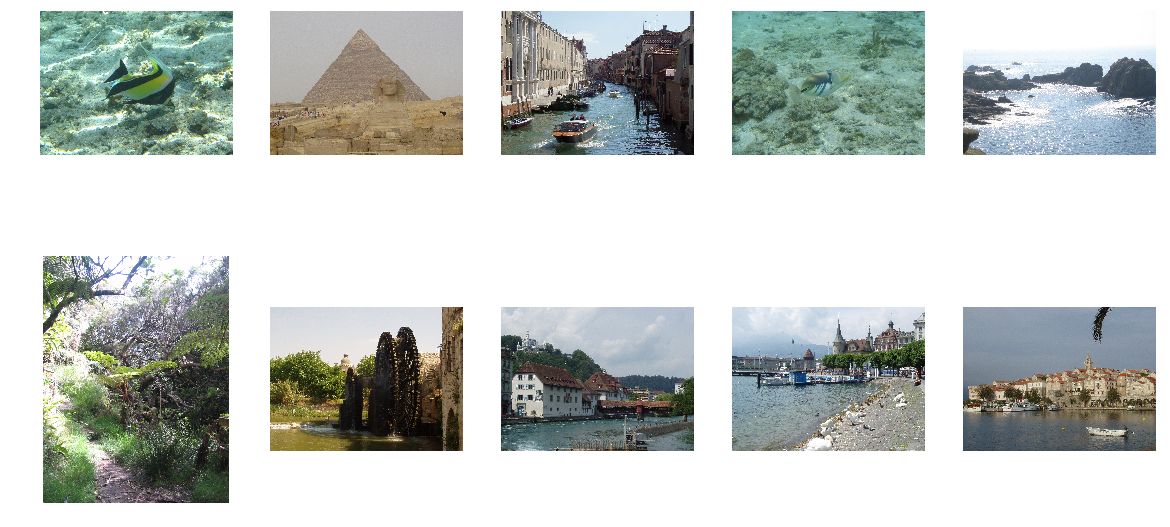

In [0]:
#plot randomly 10 images from the list
fig = plt.figure(figsize=(20,10))
cols = 5
rows =  2
for i, path in enumerate(random.choices(images,k=10)):
  img = Image.open(path)
  fig.add_subplot(rows,cols,i+1)
  plt.axis('off')
  plt.imshow(img)
plt.show()

W0530 16:29:11.076536 140275094677376 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


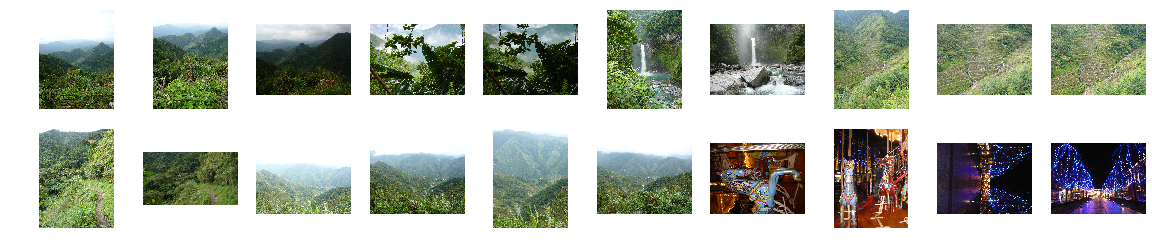

In [0]:

#plot first 20 images 

fig = plt.figure(figsize=(20,4))
cols = 10
rows =  2
for i, path in enumerate(images[0:20]):
  img = Image.open(path)
  fig.add_subplot(rows,cols,i+1)
  plt.axis('off')
  plt.imshow(img)
plt.show()

As we can see, in each group, there are images of a scene taken from different angle. Since the number of images per group is less, we can either categorize them broadly (like mountains, seas etc) or have large number of groups for each specific category. We can extract keypoint features from each images and match them to set in different groups.

There are several methods to extract the key point features, traditional ones like SIFT, SURF, ORB, etc or the recent deep learning based like DELF (DEep Local Features.). 
For this task, we will use the DELF feature provided by the tensorflow hub module. It extracts the keypoint and descriptors which can be used to match similar images by using nearest neighbor search.

In [0]:
def image_input_fn(image_files):
  
    """
    Reads the images file using tensorflow image reader and returns after preprocessing
    """
    filename_queue = tf.train.string_input_producer(
        image_files, shuffle=False)
    reader = tf.WholeFileReader()
    _, value = reader.read(filename_queue)
    image_tf = tf.image.decode_jpeg(value, channels=3)
    
    resized_images=tf.image.resize_images(image_tf,(600, 600))
    resized_images=tf.image.per_image_standardization(resized_images)  ## intensity normalization

    return tf.image.convert_image_dtype(resized_images, tf.float32)

In [0]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()               ##checks available gpus

In [0]:

##Extract feature locations and descriptors from images
##using the tf hub module 


tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 128,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn(images)
print(image_tf)

with tf.train.MonitoredSession() as sess:
    results_dict = {}  # Stores the locations and their descriptors for each image
    for image_path in images:
        image = sess.run(image_tf)
        print('Extracting locations and descriptors from %s' % image_path)
        results_dict[image_path] = sess.run(
            [module_outputs['locations'], module_outputs['descriptors']],
            feed_dict={image_placeholder: image})

In [0]:
def temp_match(results_dict, image_1_path, image_2_path):
  
    """
    Matches and returns the number of inliers from set of two images
    If images are similar, returns large number of inliers
    """
    distance_threshold =0.8

    # Read features.
    locations_1, descriptors_1 = results_dict[image_1_path]
    num_features_1 = locations_1.shape[0]
    #print("Loaded image 1's %d features" % num_features_1)
    locations_2, descriptors_2 = results_dict[image_2_path]
    num_features_2 = locations_2.shape[0]
    #print("Loaded image 2's %d features" % num_features_2)

    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(descriptors_1)
    _, indices = d1_tree.query(
        descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
    locations_2_to_use = np.array([
        locations_2[i,]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
        locations_1[indices[i],]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])

  # Perform geometric verification using RANSAC.
    _, inliers = ransac(
        (locations_1_to_use, locations_2_to_use),
        AffineTransform,
        min_samples=3,
        residual_threshold=20,
        max_trials=50)
    # the number of inliers as the score for retrieved images.
    
    if inliers is None:
      inl = 0
    else:
      inl = sum(inliers)

    #print('Found %d inliers' %(inl))
    return(inl)

   

In [0]:
### Sends a pair of images to temp_match function to calculate 
### similarity between two images.


cluster ={}  #saves the matching images in a dictionary
k=1
temp =[]
for i in images:
  temp=[]
  for j in images:
    if i !=j:
      try:
        value = temp_match(results_dict, i,j)
        if value>20:            #threshold value for 128 features length
          print(i)
          temp.append(j)
          images.remove(j)
      except:
        pass
  temp.append(i)
  images.remove(i)
  cluster[k]=temp
  k=k+1
    
          
          
          
        

In [0]:
!wget https://raw.githubusercontent.com/riteshkr54/Image_clustering/master/clusters.csv

--2019-06-02 17:02:46--  https://raw.githubusercontent.com/riteshkr54/Image_clustering/master/clusters.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10511 (10K) [text/plain]
Saving to: ‘clusters.csv’

clusters.csv        100%[===================>]  10.26K  --.-KB/s    in 0s      

2019-06-02 17:02:46 (150 MB/s) - ‘clusters.csv’ saved [10511/10511]



In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
df = pd.read_csv('clusters.csv',sep='\t')
df['length']=(df['image_list'].apply(len))/18

In [0]:
df.head()

,SNo,image_list,length
0,1,"['jpg/100001.jpg', 'jpg/100000.jpg']",2.0
1,2,"['jpg/100101.jpg', 'jpg/100100.jpg']",2.0
2,3,['jpg/100201.jpg'],1.0
3,4,"['jpg/100302.jpg', 'jpg/100301.jpg']",2.0
4,5,['jpg/100401.jpg'],1.0


In [0]:
#get the count of images in each clusters

df['length'].value_counts()

1.0    153
2.0    131
3.0     19
4.0      4
5.0      3
Name: length, dtype: int64

In [0]:
df[df['length']==4.0]

,SNo,image_list,length
9,10,"['jpg/106702.jpg', 'jpg/126804.jpg', 'jpg/1275...",4.0
14,15,"['jpg/101400.jpg', 'jpg/101402.jpg', 'jpg/1014...",4.0
15,16,"['jpg/101500.jpg', 'jpg/101502.jpg', 'jpg/1015...",4.0
48,49,"['jpg/104203.jpg', 'jpg/106501.jpg', 'jpg/1274...",4.0


Plot some sample clusters. Change the index number or cluster size to get different groups.

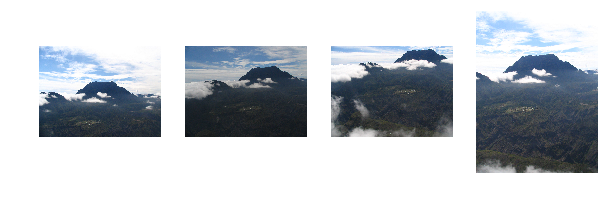

In [0]:
fig = plt.figure(figsize=(10,10))
sample_list = literal_eval(df.loc[15]['image_list'])
cols = len(sample_list)
rows=1
for i, path in enumerate(sample_list):
  img = Image.open((path))
  fig.add_subplot(rows,cols,i+1)
  plt.axis('off')
  plt.imshow(img)
plt.show()

In [0]:
df[df['length']==3.0]

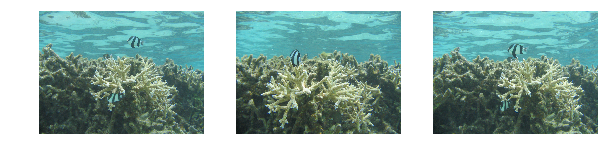

In [0]:
fig = plt.figure(figsize=(10,10))
sample_list = literal_eval(df.loc[39]['image_list'])
cols = len(sample_list)
rows=1
for i, path in enumerate(sample_list):
  img = Image.open((path))
  fig.add_subplot(rows,cols,i+1)
  plt.axis('off')
  plt.imshow(img)
plt.show()

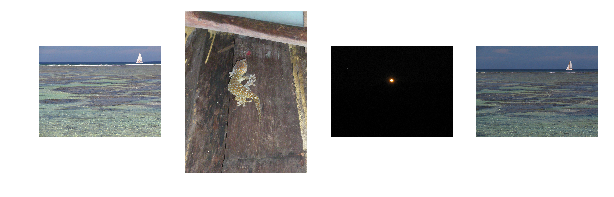

In [0]:
fig = plt.figure(figsize=(10,10))
sample_list = literal_eval(df.loc[48]['image_list'])
cols = len(sample_list)
rows=1
for i, path in enumerate(sample_list):
  img = Image.open((path))
  fig.add_subplot(rows,cols,i+1)
  plt.axis('off')
  plt.imshow(img)
plt.show()